# LangGraph를 사용한 고객 지원 챗봇을 구축

- 웹 검색을 통해 일반적인 질문에 답변 
- 대화 상태를 유지하여 연속적인 대화  
- 복잡한 질문을 사람이 검토하도록 라우팅  
- 사용자 지정 상태(Custom State)를 활용하여 챗봇의 동작 제어  
- 대화 흐름을 되돌리고(Rewind), 다른 대화 경로 탐색 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적 설정 활성화
os.environ["LANGSMITH_TRACING"] = "true"

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

먼저 모델을 직접 사용해 봅니다. `ChatModel`은 LangChain의 **"Runnable"** 인스턴스이며, 이는 표준화된 인터페이스를 통해 상호작용할 수 있음을 의미합니다.  

모델을 간단하게 호출하려면 `.invoke` 메서드에 **메시지 목록**을 전달하면 됩니다.

In [4]:
from langchain_core.messages import HumanMessage

response = llm.invoke([HumanMessage(content="안녕! 나는 길동이야.")])
response.content

'안녕, 길동! 만나서 반가워. 어떻게 도와줄까?'

모델 자체는 **상태(state)** 라는 개념을 가지고 있지 않습니다. 예를 들어, 후속 질문을 하면:

In [5]:
response = llm.invoke([HumanMessage(content="내 이름이 뭐라고 했지?")])
response.content

'죄송하지만, 제가 이전 대화 내용을 기억하지 않아서 당신의 이름을 알 수 없습니다. 혹시 알려주실 수 있나요?'

In [6]:
from langchain_core.messages import AIMessage

response = llm.invoke(
    [
        HumanMessage(content="안녕! 나는 길동이야."),
        AIMessage(content="안녕하세요, 길동님. 무엇을 도와 드릴까요?"),
        HumanMessage(content="내 이름이 뭐라고 했지?"),
    ]
)

response.content

'길동님이라고 말씀하셨어요!'

<br>
이제 좋은 응답을 받는 것을 확인할 수 있습니다!  

이것이 챗봇이 **대화형 상호작용**을 할 수 있는 기본 아이디어입니다.  

### **Part 1: 기본 챗봇 만들기¶**  

In [7]:
from typing import Annotated   # 타입 힌트를 위한 Annotated 사용
from typing_extensions import TypedDict   # 구조적 타입 지정을 위한 TypedDict 사용

# LangGraph에서 상태 그래프를 구성하기 위한 기본 클래스 및 상수 임포트
from langgraph.graph import StateGraph, START, END
# LangGraph에서 메시지를 상태에 추가하기 위한 헬퍼 함수
from langgraph.graph.message import add_messages

# 상태(State)를 정의하는 클래스
# 이 상태는 메시지 목록(messages)을 포함하며,
# add_messages는 메시지를 자동으로 병합하거나 관리하는 역할을 함
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 상태 타입을 기반으로 그래프 빌더 생성
graph_builder = StateGraph(State)

# 노드 함수 정의
# 입력 상태에서 messages를 꺼내서 LLM에게 전달하고, 
# 생성된 응답 메시지를 다시 messages에 추가하여 반환
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# "chatbot"이라는 이름의 노드를 그래프에 추가
graph_builder.add_node("chatbot", chatbot)

- 챗봇 노드 함수는 **현재 상태(State)를 입력**으로 받고, **업데이트된 메시지 리스트**를 `"messages"` 키에 담아 **딕셔너리 형태로 반환**합니다.  
- 이 패턴은 **모든 LangGraph 노드 함수의 기본 구조**입니다.  

**다음 단계:**  
- **엔트리 포인트(Entry Point)** 를 추가  
- **엔트리 포인트**는 **그래프 실행 시 시작 지점을 정의**하며, **매번 그래프를 실행할 때 어디서부터 작업을 시작할지 지정하는 역할**을 합니다.
- 마찬가지로, **종료 지점(Finish Point)** 을 설정합니다. 이는 그래프에게 **"이 노드가 실행될 때마다, 여기서 작업을 종료할 수 있다."** 라고 지시하는 역할을 합니다.
- 마지막으로, 그래프를 실행할 수 있도록 설정해야 합니다. 이를 위해 **`compile()`** 메서드를 그래프 빌더에서 호출합니다.   

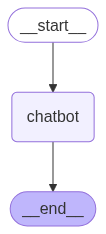

In [8]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()
graph

### **챗봇 실행**  

대화 루프에서 언제든지 **"quit"**, **"exit"**, 또는 **"q"** 를 입력하면 종료할 수 있습니다. 

In [9]:
def stream_graph_updates(user_input: str):
    """
    그래프를 스트리밍 방식으로 업데이트하는 함수
    사용자 입력을 받아, LLM이 응답하는 과정을 streaming 방식으로 출력
    """
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):  
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)  # 최신 응답 메시지를 출력


# 무한 루프 (사용자가 "quit", "exit", "q"를 입력하면 종료)
while True:
    user_input = input("사용자: ")  
    if user_input.lower() in ["quit", "exit", "q"]: 
        print("종료합니다.") 
        break

    stream_graph_updates(user_input) 

사용자:  안녕. 나는 길동이야


Assistant: 안녕, 길동이! 만나서 반가워. 오늘 어떻게 도와줄까?


사용자:  오늘 서울 날씨가 어때?


Assistant: 죄송하지만, 실시간 날씨 정보를 제공할 수 없습니다. 오늘 서울의 최신 날씨를 확인하시려면 기상청 홈페이지나 날씨 앱을 참고하시기 바랍니다.


사용자:  내 이름이 뭐지?


Assistant: 죄송하지만, 저는 당신의 이름을 알지 못해요. 혹시 알려주실 수 있나요?


사용자:  q


종료합니다.


LangGraph를 사용하여 첫 번째 챗봇을 구축 했습니다.  하지만 현재는 외부 정보도 가져오지 못하고, 사용자의 이름도 기억하지 못합니다.

다음 단계에서는 웹 검색 도구를 추가하여 챗봇의 지식을 확장하고, 더 강력한 기능을 갖추도록 만들겠습니다. 

## **Part 2: 도구를 활용한 챗봇 강화**   
이제 챗봇이 **웹에서 관련 정보를 찾아 더 나은 답변을 제공할 수 있도록 개선**합니다. 

---
먼저 **Tavily 검색 엔진**을 사용하기 위해 필요한 패키지를 설치하고 **`TAVILY_API_KEY`** 를 설정 합니다.  

In [14]:
# %%capture --no-stderr
#%pip install -U langchain-tavily

In [15]:
# Tavily 검색 툴을 임포트
# Tavily는 웹 검색을 통해 정보를 가져오는 도구로, LangChain에서 도구(tool)로 활용 가능
from langchain_tavily import TavilySearch

# TavilySearch 툴 인스턴스를 생성 (최대 결과 2개로 제한)
tool = TavilySearch(max_results=2)

# 사용할 툴들을 리스트로 구성 (여러 개의 도구가 필요한 경우를 대비해 리스트 형태로 작성)
tools = [tool]

# Tavily 검색 도구를 직접 호출하여 "LangGraph에서 node가 뭐야?"라는 질문에 대한 웹 검색 결과를 가져옴
result = tool.invoke("LangGraph에서 node가 뭐야?")
print(result)

{'query': 'LangGraph에서 node가 뭐야?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '[LangGraph] Graph 기본 개념', 'url': 'https://databoom.tistory.com/entry/LangGraph-Graph-기본-개념', 'content': 'langchain 버전: 0.3.23langgraph 버전: 0.3.31내용 출처 : LangGrapn Docs 1. Graph 개념LangGraph는 Graph를 구성해 Agent를 만들 수 있다. Graph의 핵심 구성은 다음과 같다.Graph(그래프) : 노드(Node, 또는 정점 Vertex) 와 간선(Edge) 으로 이루어진 자료구조Node(노드) : 그래프 내의 개체. 작업 단위(Task). 주로 Tool과 chatbot이 오게', 'score': 0.8020137, 'raw_content': None}, {'title': 'LangGraph 쉽게 이해하기: 초보자를 위한 가이드', 'url': 'https://memoryhub.tistory.com/entry/LangGraph-쉽게-이해하기-초보자를-위한-가이드-🌟', 'content': '안녕하세요! 오늘은 LLM 애플리케이션 개발에 큰 도움이 되는 LangGraph를 정말 쉽게 설명해 드릴게요. 처음부터 차근차근 알아봅시다!LangGraph란 무엇인가요? 🤔여러분이 좋아하는 요리 레시피를 생각해보세요:재료 준비하기야채 썰기고기 볶기소스 넣기간 맞추기완성!LangGraph는 바로 이런 레시피 같은', 'score': 0.27961746, 'raw_content': None}], 'response_time': 1.85}


In [ ]:
# pip install -U "langchain[openai]"

### 도구(Tools)를 실행하는 함수 생성하기
이제, 도구가 호출되는 경우 이를 실행하는 함수를 만들어봅시다.  
이를 위해 `llm_with_tools`라는 새 노드를 만들고, 여기에 도구들을 추가합니다.  
이 노드는 상태(state)에서 가장 최근 메시지를 확인하고, 그 메시지에 tool_calls가 포함되어 있는 경우 해당 도구들을 호출합니다.

이 기능은 Anthropic, OpenAI, Google Gemini 및 여러 다른 LLM 제공업체에서 지원하는 tool calling 기능을 기반으로 동작합니다.  

In [16]:
from typing import Annotated  # Annotated 타입을 사용하기 위한 모듈 (타입에 메타데이터 부여)
from typing_extensions import TypedDict  # TypedDict는 딕셔너리 구조에 타입 힌트를 부여할 수 있게 해줌

# LangGraph에서 상태 그래프 구성 관련 기능과 상수 가져오기
from langgraph.graph import StateGraph, START, END
# LangGraph의 메시지 병합 기능: 메시지를 상태에 병합하거나 정리하는 헬퍼 함수
from langgraph.graph.message import add_messages

# 상태(State) 클래스 정의
# 'messages'는 Annotated를 사용해 LangGraph의 메시지 병합 기능(add_messages)을 적용
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 상태(State)를 기반으로 하는 그래프 빌더 생성
graph_builder = StateGraph(State)

# 사용할 도구들을 LLM에 명시적으로 바인딩 (Tool Calling 지원)
# 이를 통해 LLM이 명시된 도구만 호출할 수 있도록 제한
llm_with_tools = llm.bind_tools(tools)

# 챗봇 노드 함수 정의
# 현재 상태의 messages를 LLM에 전달하여 응답을 생성하고,
# 그 응답 메시지를 다시 상태에 포함되도록 반환
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 'chatbot'이라는 이름의 노드를 그래프에 추가
# LangGraph 내부에서 이 노드는 하나의 처리 단위로 동작함
graph_builder.add_node("chatbot", chatbot)

In [17]:
# LangChain에서 tool 호출 결과를 감싸기 위한 메시지 타입
from langchain_core.messages import ToolMessage

# 도구 실행 노드 정의
class BasicToolNode:
    """마지막 AIMessage에 포함된 tool_calls를 실행하는 노드"""

    def __init__(self, tools: list) -> None:
        # 도구 이름을 키로 하여 도구 인스턴스를 딕셔너리로 저장
        # 예: {'SearchTool': SearchTool 객체}
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 입력에서 messages 리스트를 꺼냄 (없으면 빈 리스트)
        if messages := inputs.get("messages", []):
            # 가장 마지막 메시지를 가져옴 (보통 AIMessage)
            message = messages[-1]
        else:
            raise ValueError("입력에 message가 없습니다")

        outputs = []

        # AIMessage에 포함된 tool_calls 순회
        for tool_call in message.tool_calls:
            # 도구 이름으로 매칭된 도구를 찾아 호출
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]  # 도구 호출에 필요한 인자
            )

            # 도구 호출 결과를 ToolMessage로 감싸고 outputs에 추가
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),   # JSON 문자열로 변환
                    name=tool_call["name"],            # 도구 이름
                    tool_call_id=tool_call["id"],      # 도구 호출 ID (LLM이 생성함)
                )
            )

        # 처리된 메시지 목록을 반환 (상태 업데이트 용도)
        return {"messages": outputs}

# 위에서 정의한 도구 실행 노드를 그래프에 추가
# "tools"라는 이름의 노드로 추가되어 이후 그래프 실행 시 이 노드를 호출함
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

**조건부 엣지(Conditional Edges)의 동작 방식**  

- 조건부 엣지는 특정 노드에서 시작됩니다. 즉, 'chatbot' 노드가 실행될 때마다, 다음과 같은 경로를 결정합니다.

1️) 만약 챗봇이 도구(`tool_calls`)를 호출하면 'tools' 노드로 이동   
2️) 만약 챗봇이 직접 응답하면 `END`로 이동하여 실행 종료


**`tools_condition`**  

- **`tool_calls`가 없는 경우 `END` 문자열을 반환하여 실행을 종료** 합니다.  

In [18]:
def route_tools(state: State):
    """
    조건부 엣지(conditional_edge)에서 사용될 함수.
    마지막 메시지에 tool_calls가 있으면 "tools" 노드로 라우팅하고,
    그렇지 않으면 END로 라우팅한다.
    """

    # 상태가 리스트 타입일 경우 마지막 메시지를 가져옴
    if isinstance(state, list):
        ai_message = state[-1]

    # 상태 딕셔너리에서 'messages' 키를 통해 메시지 리스트를 가져와 마지막 메시지를 선택
    elif messages := state.get("messages", []):
        ai_message = messages[-1]

    else:
        # 메시지가 없을 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # 마지막 메시지가 tool_calls 속성을 가지고 있고, 하나 이상 도구 호출이 있을 경우
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # tools 노드로 이동

    return END  # 그 외에는 종료 노드로 이동


# 조건부 엣지를 추가하여, chatbot 노드 이후 흐름을 동적으로 제어
# chatbot이 도구 호출을 요청하면 tools 노드로, 아니면 END로 흐름이 결정됨
graph_builder.add_conditional_edges(
    "chatbot",       # 조건부 분기 시작 노드
    route_tools,     # 조건 판단 함수
    {
        "tools": "tools",  # 판단 결과가 "tools"이면 tools 노드로 이동
        END: END,          # 판단 결과가 END면 그래프 종료
    }
)

# 도구를 호출한 이후에는 다시 chatbot 노드로 돌아가서 다음 행동 결정
graph_builder.add_edge("tools", "chatbot")

# 그래프의 시작점에서 chatbot 노드로 진입
graph_builder.add_edge(START, "chatbot")

# 모든 노드와 엣지가 정의된 후 그래프를 컴파일 (실행 준비 완료)
graph = graph_builder.compile()

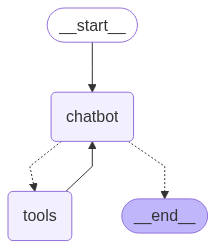

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이제 챗봇에게 **훈련 데이터에 없는 질문도 할 수 있습니다.** 

In [20]:
import json
from langchain_core.messages import AIMessage

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if isinstance(value["messages"][-1], AIMessage):
                last_msg = value["messages"][-1].content
            if len(last_msg) > 0:
                print("Assistant:", last_msg)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

User:  안녕, 나는 길동이야


Assistant: 안녕하세요, 길동님! 어떻게 도와드릴까요?


User:  오늘 서울의 날씨가 어때?


Assistant: 오늘 서울의 날씨는 약 65°F(약 18°C)로 쾌적하며, 현재 맑은 상태입니다. 자세한 내용은 [AccuWeather](https://www.accuweather.com/ko/kr/seoul/226081/hourly-weather-forecast/226081) 또는 [The Weather Channel](https://weather.com/ko-KR/weather/today/l/82e46175f97c224acf6b95afc4934fbae0e4ba123adcee8a52b7be97c303467b)에서 확인하실 수 있습니다.


User:  내 이름이 뭐였지?


Assistant: 죄송하지만, 지금까지의 대화에서 사용자님의 이름을 알 수 있는 정보가 없습니다. 이름을 알려주시면 기억해둘 수 있습니다.


User:  q


Goodbye!


이제 LangGraph에서 검색 엔진을 활용할 수 있는 대화형 에이전트(Conversational Agent)를 만들었습니다

--- 

## **Part 3: 챗봇에 메모리 기능 추가¶**  

현재 챗봇은 **사용자 질문에 도구를 활용해 답변할 수 있지만, 이전 대화의 맥락을 기억하지 못합니다.**  
이 때문에 **일관된 멀티턴(Multi-turn) 대화를 진행하는 데 한계가 있습니다.**  

LangGraph는 **"지속적 체크포인트(Persistent Checkpointing)"** 기능을 통해 이 문제를 해결합니다.  

그래프를 컴파일할 때 checkpointing을 활성화하고 그래프를 호출할 때 `thread_id`를 제공하면, LangGraph가 자동으로 상태(state)를 저장하고, 다음 실행 시 이전 상태를 복원합니다.  

즉, **동일한 `thread_id`** 를 사용하여 그래프를 호출하면, 이전 대화 상태를 불러와서 이어서 대화할 수 있습니다!

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

우리는 현재 **메모리를 활용하는(in-memory) 체크포인터**를 사용하고 있습니다.  

이 방식은 튜토리얼 환경에서는 편리하지만, 데이터가 메모리에만 저장되므로 영구적이지 않습니다. 실제 프로덕션 환경에서는 `SqliteSaver` 또는 `PostgresSaver`를 사용하여 데이터베이스(DB)와 연결하는 것이 일반적입니다.

---

In [22]:
# 상태(State)를 정의한 후, 이를 기반으로 하는 그래프 생성
graph_builder = StateGraph(State)

# LLM에 사용할 도구(tool) 목록을 바인딩함
llm_with_tools = llm.bind_tools(tools)

# chatbot 노드 정의: 현재 상태(state)의 메시지를 LLM에 넘겨 응답 메시지를 반환
def chatbot(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

# chatbot 노드를 그래프에 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 실행 노드 정의 및 추가
# 가장 최근 AI 메시지에 포함된 도구 호출 요청(tool_calls)을 실행하고 결과 메시지 반환
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# chatbot → tools 또는 chatbot → END 로 분기되는 조건부 엣지 추가
# route_tools 함수는 마지막 메시지에 도구 호출이 있는지를 확인하여 흐름 결정
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "tools": "tools",  # 도구 호출이 있으면 tools 노드로 이동
        END: END           # 도구 호출이 없으면 종료
    },
)

# 도구 실행이 끝난 뒤에는 다시 chatbot 으로 돌아가 대화를 계속함
graph_builder.add_edge("tools", "chatbot")

# 그래프의 시작 지점은 chatbot 노드
graph_builder.add_edge(START, "chatbot")

# 최종적으로 모든 구성 요소를 포함해 그래프를 컴파일함
# memory는 대화 상태를 저장하는 체크포인트 기능 (예: thread_id로 상태 추적)
graph = graph_builder.compile(checkpointer=memory)

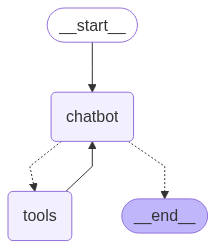

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

이제 챗봇과 상호작용할 수 있습니다. 먼저, 이 대화를 식별할 수 있는 **`thread`(스레드)** 를 선택합니다.

In [24]:
config = {"configurable": {"thread_id": "1"}}

user_input = "안녕하세요! 제 이름은 길동이에요."

# config는 stream() 또는 invoke()의 두 번째 인자
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 길동이에요.
================================== Ai Message ==================================

안녕하세요, 길동님! 만나서 반가워요. 오늘 어떻게 도와드릴까요?


이제 후속 질문(follow-up question)을 해봅시다. 챗봇이 사용자의 이름을 기억하는지 확인해 봅니다.

In [25]:
user_input = "내 이름이 뭐야? 그리고 오늘 서울의 날씨는 어때?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름이 뭐야? 그리고 오늘 서울의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_AUHTUDJUQaDbhlNpWYoQz7bp)
 Call ID: call_AUHTUDJUQaDbhlNpWYoQz7bp
  Args:
    query: 길동이 이름
================================= Tool Message =================================
Name: tavily_search

{"query": "\uae38\ub3d9\uc774 \uc774\ub984", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "\uace0\uae38\ub3d9 - \ub098\ubb34\uc704\ud0a4", "url": "https://namu.wiki/w/\uace0\uae38\ub3d9", "content": "\uc544\uae30\uacf5\ub8e1 \ub458\ub9ac \uc758 \uc8fc\uc5ed \uc911 \ud558\ub098\uc774\uc790 \ub610 \ub2e4\ub978 \uc8fc\uc778\uacf5. \uc11c\uc6b8\ud2b9\ubcc4\uc2dc \ub3c4\ubd09\uad6c \uc30d\ubb38\ub3d9 [18] \uc5d0 \uc0ac\ub294 \ud3c9\ubc94\ud55c \uc0d0\ub7ec\ub9ac\ub9e8\uc73c\ub85c \uc9c1\uae09\uc740 \uacfc\uc7a5 (\uc774\ub978\ubc14 \ub9cc\ub144

In [27]:
# `thread_id`를 "1" 대신 "2"로 변경합니다.
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름이 뭐야? 그리고 오늘 서울의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_yqnLMjrviSp79Jyh6HJoIEA3)
 Call ID: call_yqnLMjrviSp79Jyh6HJoIEA3
  Args:
    query: 내 이름이 뭐야?
  tavily_search (call_EKWs2XfX6rx7g0x6hDuprFZt)
 Call ID: call_EKWs2XfX6rx7g0x6hDuprFZt
  Args:
    query: 서울 오늘 날씨
================================= Tool Message =================================
Name: tavily_search

{"query": "\uc11c\uc6b8 \uc624\ub298 \ub0a0\uc528", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc, \ub300\ud55c\ubbfc\uad6d \uc2dc\uac04\ubcc4 \ub0a0\uc528 | AccuWeather", "url": "https://www.accuweather.com/ko/kr/seoul/226081/hourly-weather-forecast/226081", "content": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc, \ub300\ud55c\ubbfc\uad6d \uc2dc\uac04\ubcc4 \ub0a0

---
지금까지 두 개의 서로 다른 thread에서 여러 개의 체크포인트를 생성했습니다. 체크포인트에는 어떤 정보가 저장되는 정보는 다음과 같습니다. 

- 현재 상태 값(Current State Values) 
- 해당 상태와 연결된 `config` 정보  
- 다음으로 처리할 노드(Next Node to Process) 

In [28]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='안녕하세요! 제 이름은 길동이에요.', additional_kwargs={}, response_metadata={}, id='69056316-53bc-4512-b18a-5bdbb4e3d9a1'), AIMessage(content='안녕하세요, 길동님! 만나서 반가워요. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 778, 'total_tokens': 801, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'finish_reason': 'stop', 'logprobs': None}, id='run-dae07f3b-504c-45ed-98cd-a5fad9c45e35-0', usage_metadata={'input_tokens': 778, 'output_tokens': 23, 'total_tokens': 801, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='내 이름이 뭐야? 그리고 오늘 서울의 날씨는 어때?', additional_kwa

In [29]:
# 현재 상태 값
snapshot.values

{'messages': [HumanMessage(content='안녕하세요! 제 이름은 길동이에요.', additional_kwargs={}, response_metadata={}, id='69056316-53bc-4512-b18a-5bdbb4e3d9a1'),
  AIMessage(content='안녕하세요, 길동님! 만나서 반가워요. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 778, 'total_tokens': 801, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'finish_reason': 'stop', 'logprobs': None}, id='run-dae07f3b-504c-45ed-98cd-a5fad9c45e35-0', usage_metadata={'input_tokens': 778, 'output_tokens': 23, 'total_tokens': 801, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='내 이름이 뭐야? 그리고 오늘 서울의 날씨는 어때?', additional_kwargs={}, response_

In [30]:
# 해당 상태와 관련된 config 정보
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f049c5c-1d3f-6de0-8008-8bb00ae5268f'}}

In [31]:
# 다음으로 처리할 node
snapshot.next

()

### 프롬프트 템플릿(Prompt Templates)을 사용하여 LLM 호출 최적화

**프롬프트 템플릿** 은 **원시 사용자 입력(raw user input)** 을 LLM이 처리할 수 있는 형식으로 변환하는 데 도움을 줍니다.   

1. 먼저, **시스템 메시지(system message)** 를 추가하여 **사용자 정의 지침(custom instructions)** 을 포함시킵니다. (여전히 메시지를 입력으로 사용)  
2. 다음으로, 메시지 외에 **더 많은 입력 정보** 를 추가합니다.  

#### **시스템 메시지(System Message) 추가하기**

시스템 메시지를 추가하기 위해 **`ChatPromptTemplate`** 을 생성합니다. 여기서는 메시지 전달을 위해 **`MessagesPlaceholder`** 를 사용하겠습니다.  

이렇게 하면 LLM에 전달되는 입력이 더 구조화되고, 챗봇의 동작을 더 정교하게 제어할 수 있습니다.  

In [32]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# LLM이 사용자 입력을 더 잘 처리할 수 있도록 프롬프트 템플릿을 설정합니다.
prompt_template = ChatPromptTemplate.from_messages(
    [
        # LLM의 동작 방식을 정의하는 지침
        (
            "system",
            "당신은 친구 처럼 말합니다. 모든 질문에 최선을 다해 대답하세요.",
        ),

        # Messages Placeholder - 이전 대화 메시지들을 전달합
        MessagesPlaceholder(variable_name="messages"),
    ]
)

이제 이 템플릿을 통합하여 애플리케이션을 업데이트할 수 있습니다.

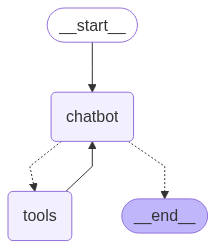

In [33]:
# 상태 스키마(State)를 정의하여 그래프 생성기 초기화
graph_builder = StateGraph(state_schema=State)

# LLM에 사용할 도구(tool)들을 바인딩하여, LLM이 도구 호출 기능을 사용할 수 있도록 설정
llm_with_tools = llm.bind_tools(tools)

# 모델 호출 함수 정의
def chatbot(state: State):
    # 현재 상태(state)에 포함된 메시지를 기반으로 프롬프트 생성
    prompt = prompt_template.invoke(state)
    
    # 생성된 프롬프트를 LLM에 전달하여 응답을 생성
    response = llm_with_tools.invoke(prompt)
    
    # LLM 응답을 딕셔너리 형태로 반환 (다음 상태로 전달됨)
    return {"messages": response}

# chatbot 노드를 그래프에 추가
graph_builder.add_node("chatbot", chatbot)

# 툴 실행 노드 정의 및 추가
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# chatbot 노드에서의 조건부 흐름 정의
# route_tools 함수는 마지막 메시지에 도구 호출이 포함되어 있는지 판단
# 도구 호출이 있으면 "tools" 노드로, 없으면 END로 이동
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

# MemorySaver를 사용하여 대화 상태를 저장할 메모리 객체 생성
memory = MemorySaver()

# 도구 실행 후 다시 chatbot 으로 흐름을 연결 (반복 가능)
graph_builder.add_edge("tools", "chatbot")

# 그래프의 시작 지점(START)에서 chatbot 노드로 연결
graph_builder.add_edge(START, "chatbot")

# 모든 구성 요소를 종합하여 그래프를 컴파일 (메모리를 체크포인터로 사용)
graph = graph_builder.compile(checkpointer=memory)

# 컴파일된 그래프 객체를 확인
graph

In [34]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
config = {"configurable": {"thread_id": "abc345"}}

# 메시지 목록에 사용자 메시지 추가
input_messages = [HumanMessage("안녕. 나는 길동이야.")]

# 애플리케이션 호출
# 메시지 상태(State), 설정(config) 전달
output = graph.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕 길동이! 반가워. 오늘은 어떤 이야기 나누고 싶어?


In [35]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
config = {"configurable": {"thread_id": "abc345"}}

# 메시지 목록에 사용자 메시지 추가
input_messages = [HumanMessage("내 이름이 뭐지?")]

# 애플리케이션 호출
# 메시지 상태(State), 설정(config) 전달
output = graph.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

네 이름은 길동이야! 맞지?


In [36]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
memory = MemorySaver()

# 그래프를 메모리 체크포인트와 함께 컴파일합니다.
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc345"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    output = graph.invoke({"messages": user_input}, config)
    output["messages"][-1].pretty_print()

User:  안녕. 나는 길동이야


================================== Ai Message ==================================

안녕, 길동아! 반가워. 오늘 어떻게 도와줄까?


User:  오늘 서울의 날씨가 어때?


================================== Ai Message ==================================

오늘 서울의 날씨는 대체로 맑고 쾌적한 편이야. 기온은 약 31도 정도이고, 습도는 60% 정도야. 바람은 시속 6km/h로 부는 상태야. 오늘 하루도 좋은 하루 보내길 바랄게!


User:  내 이름이 뭐였지?


================================== Ai Message ==================================

네 이름은 길동이었지! 기억하고 있어. 혹시 더 궁금한 거 있으면 말해줘!


User:  q


Goodbye!


------------
이제는 chatbot이 외부 정보를 접근할 수도 있고 대화 내용을 기억할 수도 있습니다.